<a href="https://colab.research.google.com/github/sherlockieee/cs156-final-project/blob/main/K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from fuzzywuzzy import fuzz, process
except: 
    !pip install fuzzywuzzy
    !pip install python-Levenshtein


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/CS156_final/processed_response.zip')

#df1 = pd.read_csv('/content/drive/MyDrive/Assignment/CS156/CS156_final/processed_response.zip')

In [4]:
df1.shape

(191016, 10)

In [5]:
df1.head()

,Polls ID,Assessment reports Student ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string
0,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0,1,"['The', 'strengths', 'of', ""Plato's"", 'approac...","['the', 'strength', 'of', 'plato', 'approach',...","['strength', 'plato', 'approach', 'construct',...",strength plato approach construct whole framew...
1,12522.0,335.0,In the breakout we discussed if outside the ca...,#objectivemorality,3.0,1,"['In', 'the', 'breakout', 'we', 'discussed', '...","['in', 'the', 'breakout', 'we', 'discuss', 'if...","['breakout', 'discuss', 'outsid', 'cave', 'mig...",breakout discuss outsid cave might bigger cave...
2,12522.0,333.0,"I think he's good at reasoning, but he has thi...",#deductivearg,2.0,1,"['I', 'think', ""he's"", 'good', 'at', 'reasonin...","['i', 'think', 'he', 'good', 'at', 'reason', '...","['think', 'good', 'reason', 'circular', 'way',...",think good reason circular way prove point onl...
3,12522.0,318.0,Back to cmmon confusion time: the section 'und...,#objectivemorality,2.0,1,"['Back', 'to', 'cmmon', 'confusion', 'time', '...","['back', 'to', 'cmmon', 'confus', 'time', 'the...","['back', 'cmmon', 'confus', 'time', 'section',...",back cmmon confus time section understand inte...
4,12522.0,315.0,Most difficult weakness is that his position w...,#objectivemorality,2.0,1,"['Most', 'difficult', 'weakness', 'is', 'that'...","['most', 'difficult', 'weak', 'is', 'that', 'h...","['difficult', 'weak', 'posit', 'understand', '...",difficult weak posit understand testabl like i...


In [6]:
df1['string'] = df1['string'].values.astype('U')

In [7]:
los = pd.read_csv("/content/drive/MyDrive/CS156_final/LOs Master List - LOs.csv")

#los = pd.read_csv("/content/drive/MyDrive/Assignment/CS156/CS156_final/LOs Master List - LOs.csv")
print(los.shape)
los.head()


(622, 6)


,College,Course,LO (please exclude the hashtag),Rubric,Description,Last Update
0,Arts & Humanities,NaN,NaN,NaN,NaN,NaN
1,AH,AH110,globalruptures,https://forum.minerva.edu/app/outcome-index/le...,"Analyze how economic, social, political, intel...",Dec/2020
2,AH,AH110,globalpast,https://forum.minerva.edu/app/outcome-index/le...,Place a historical phenomenon in global perspe...,NaN
3,AH,AH110,glocalization,https://forum.minerva.edu/app/outcome-index/le...,Analyze the mutually-impacting relationship be...,NaN
4,AH,AH110,historicaldebate,https://forum.minerva.edu/app/outcome-index/le...,Analyze the way in which secondary sources on ...,NaN


In [8]:
los = los[los['LO (please exclude the hashtag)'].notnull()]
los['LOs/ HCs'] = np.where(los['LO (please exclude the hashtag)'].str[0] == '#', los['LO (please exclude the hashtag)'].apply(str.lower).str[1:], los['LO (please exclude the hashtag)'].str.lower())
los = los.filter(['College', 'Course', 'LOs/ HCs'], axis = 1)

los.head()

,College,Course,LOs/ HCs
1,AH,AH110,globalruptures
2,AH,AH110,globalpast
3,AH,AH110,glocalization
4,AH,AH110,historicaldebate
5,AH,AH110,historicalperspective


In [9]:
hcs = pd.read_csv("/content/drive/MyDrive/CS156_final/HCs.csv")
# hcs = pd.read_csv("/content/drive/MyDrive/Assignment/CS156/CS156_final/HCs.csv")
hcs.head()

,HC (resources on the Hub),Course,Competency,Brief description (own words),Priority level for PRODUCT,Plans for use,Updates on actual usage,Evidence of strong applications,Other notes
0,#confidenceintervals,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
1,#correlation,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
2,#descriptivestats,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
3,#distributions,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
4,#probability,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
hcs["College"] = hcs["Course"].map({"FA": "CS", "EA": "NS", "MC": "AH", "CX": "SS"})
hcs["LOs/ HCs"] = hcs["HC (resources on the Hub)"].apply(str.lower).str[2:]

hcs = hcs.filter(["LOs/ HCs", "College"])
hcs.head()

,LOs/ HCs,College
0,confidenceintervals,CS
1,correlation,CS
2,descriptivestats,CS
3,distributions,CS
4,probability,CS


In [11]:
hcs_and_los = pd.concat([hcs, los], axis = 0)
print(hcs_and_los.shape)
print(len(hcs_and_los["LOs/ HCs"].unique()))

hcs_and_los = hcs_and_los.drop_duplicates(subset='LOs/ HCs', keep='last')
print(hcs_and_los.shape)



(695, 3)
632
(632, 3)


In [12]:
df1['LOs/ HCs'] = np.where(df1['Assessment reports Hashtag'].str[0] == '#', df1['Assessment reports Hashtag'].apply(str.lower).str[1:], df1['Assessment reports Hashtag'].str.lower())
df1 = df1[df1["string"].notnull()]
df1.head()

,Polls ID,Assessment reports Student ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs
0,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0,1,"['The', 'strengths', 'of', ""Plato's"", 'approac...","['the', 'strength', 'of', 'plato', 'approach',...","['strength', 'plato', 'approach', 'construct',...",strength plato approach construct whole framew...,objectivemorality
1,12522.0,335.0,In the breakout we discussed if outside the ca...,#objectivemorality,3.0,1,"['In', 'the', 'breakout', 'we', 'discussed', '...","['in', 'the', 'breakout', 'we', 'discuss', 'if...","['breakout', 'discuss', 'outsid', 'cave', 'mig...",breakout discuss outsid cave might bigger cave...,objectivemorality
2,12522.0,333.0,"I think he's good at reasoning, but he has thi...",#deductivearg,2.0,1,"['I', 'think', ""he's"", 'good', 'at', 'reasonin...","['i', 'think', 'he', 'good', 'at', 'reason', '...","['think', 'good', 'reason', 'circular', 'way',...",think good reason circular way prove point onl...,deductivearg
3,12522.0,318.0,Back to cmmon confusion time: the section 'und...,#objectivemorality,2.0,1,"['Back', 'to', 'cmmon', 'confusion', 'time', '...","['back', 'to', 'cmmon', 'confus', 'time', 'the...","['back', 'cmmon', 'confus', 'time', 'section',...",back cmmon confus time section understand inte...,objectivemorality
4,12522.0,315.0,Most difficult weakness is that his position w...,#objectivemorality,2.0,1,"['Most', 'difficult', 'weakness', 'is', 'that'...","['most', 'difficult', 'weak', 'is', 'that', 'h...","['difficult', 'weak', 'posit', 'understand', '...",difficult weak posit understand testabl like i...,objectivemorality


In [13]:
outer_df = pd.merge(df1, hcs_and_los, on='LOs/ HCs', how='outer')

print(outer_df.shape)
outer_df.head()

(191128, 13)


,Polls ID,Assessment reports Student ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs,College,Course
0,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0,1.0,"['The', 'strengths', 'of', ""Plato's"", 'approac...","['the', 'strength', 'of', 'plato', 'approach',...","['strength', 'plato', 'approach', 'construct',...",strength plato approach construct whole framew...,objectivemorality,NaN,NaN
1,12522.0,335.0,In the breakout we discussed if outside the ca...,#objectivemorality,3.0,1.0,"['In', 'the', 'breakout', 'we', 'discussed', '...","['in', 'the', 'breakout', 'we', 'discuss', 'if...","['breakout', 'discuss', 'outsid', 'cave', 'mig...",breakout discuss outsid cave might bigger cave...,objectivemorality,NaN,NaN
2,12522.0,318.0,Back to cmmon confusion time: the section 'und...,#objectivemorality,2.0,1.0,"['Back', 'to', 'cmmon', 'confusion', 'time', '...","['back', 'to', 'cmmon', 'confus', 'time', 'the...","['back', 'cmmon', 'confus', 'time', 'section',...",back cmmon confus time section understand inte...,objectivemorality,NaN,NaN
3,12522.0,315.0,Most difficult weakness is that his position w...,#objectivemorality,2.0,1.0,"['Most', 'difficult', 'weakness', 'is', 'that'...","['most', 'difficult', 'weak', 'is', 'that', 'h...","['difficult', 'weak', 'posit', 'understand', '...",difficult weak posit understand testabl like i...,objectivemorality,NaN,NaN
4,12522.0,297.0,I'm still trying to understand the significanc...,#objectivemorality,2.0,1.0,"[""I'm"", 'still', 'trying', 'to', 'understand',...","[""i'm"", 'still', 'tri', 'to', 'understand', 't...","[""i'm"", 'still', 'tri', 'understand', 'signifi...",i'm still tri understand signific cave analog ...,objectivemorality,NaN,NaN


In [14]:
#in original dataset
unmatched = outer_df[outer_df["College"].isna()]["LOs/ HCs"].unique()
print(sorted(unmatched))
print(len(unmatched))

[' theoreticallevelsofanalysis', 'accountability', 'accountingrules', 'agentsanddevelopment', 'aidtrade', 'alftools', 'algorithmicstrategies', 'analyticalenterprise', 'approxandscaling', 'artcommtheory', 'basicneeds', 'biochem', 'biologicalnetworks', 'bionetworks', 'bodyethics', 'brand', 'brandarchitecture', 'brandmeaning', 'brettonwoods', 'buckinghampi', 'buckinghampiscaling', 'businesscycyles', 'businessstrategy', 'casestudies', 'causalityframeworks', 'changestrategies', 'civicengagement', 'classystems', 'cognitionandemotionintegration', 'cognitionandperception', 'cognitivepersuasion', 'coherentjustice', 'collaboration', 'coloniallegacies', 'comparativeanalysis', 'competitiveanalysis', 'competitiveproductvalue', 'compssapplication', 'compsscommunication', 'compssdata', 'compssmethods', 'conceptacquisition', 'conceptsandperception', 'connectivity', 'consequences', 'controlgroups', 'creativeheuristics', 'dac', 'dcf', 'debates', 'decisionselection', 'deductivearg', 'democracy', 'designs

In [15]:
for lo in unmatched:
    best_match = process.extractOne(lo, hcs_and_los["LOs/ HCs"])
    if best_match[1] <= 70:
        continue
    df1.loc[df1['LOs/ HCs'] == lo, 'LOs/ HCs'] = best_match[0]

df = df1.merge(hcs_and_los, on='LOs/ HCs', how='inner')
df

,Polls ID,Assessment reports Student ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs,College,Course
0,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0,1,"['The', 'strengths', 'of', ""Plato's"", 'approac...","['the', 'strength', 'of', 'plato', 'approach',...","['strength', 'plato', 'approach', 'construct',...",strength plato approach construct whole framew...,objmorality,AH,AH111
1,12522.0,335.0,In the breakout we discussed if outside the ca...,#objectivemorality,3.0,1,"['In', 'the', 'breakout', 'we', 'discussed', '...","['in', 'the', 'breakout', 'we', 'discuss', 'if...","['breakout', 'discuss', 'outsid', 'cave', 'mig...",breakout discuss outsid cave might bigger cave...,objmorality,AH,AH111
2,12522.0,318.0,Back to cmmon confusion time: the section 'und...,#objectivemorality,2.0,1,"['Back', 'to', 'cmmon', 'confusion', 'time', '...","['back', 'to', 'cmmon', 'confus', 'time', 'the...","['back', 'cmmon', 'confus', 'time', 'section',...",back cmmon confus time section understand inte...,objmorality,AH,AH111
3,12522.0,315.0,Most difficult weakness is that his position w...,#objectivemorality,2.0,1,"['Most', 'difficult', 'weakness', 'is', 'that'...","['most', 'difficult', 'weak', 'is', 'that', 'h...","['difficult', 'weak', 'posit', 'understand', '...",difficult weak posit understand testabl like i...,objmorality,AH,AH111
4,12522.0,297.0,I'm still trying to understand the significanc...,#objectivemorality,2.0,1,"[""I'm"", 'still', 'trying', 'to', 'understand',...","[""i'm"", 'still', 'tri', 'to', 'understand', 't...","[""i'm"", 'still', 'tri', 'understand', 'signifi...",i'm still tri understand signific cave analog ...,objmorality,AH,AH111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179971,320721.0,301.0,Emailed it to you earlier. The explanation in ...,#IsingModel,4.0,15312,"['Emailed', 'it', 'to', 'you', 'earlier', 'The...","['email', 'it', 'to', 'you', 'earlier', 'the',...","['email', 'earlier', 'explan', 'cosh', 'expres...",email earlier explan cosh express larger one t...,isingmodel,NS,NS162
179972,320721.0,30.0,https://docs.google.com/document/d/JUbBIZWdCAW...,#IsingModel,4.0,15312,"['https', 'docs', 'google', 'com', 'document',...","['https', 'doc', 'googl', 'com', 'document', '...","['https', 'doc', 'googl', 'com', 'document', '...",https doc googl com document jubbizwdcawhf_tnv...,isingmodel,NS,NS162
179973,320721.0,236.0,https://docs.google.com/document/d/LBhIrfvdqPf...,#IsingModel,4.0,15312,"['https', 'docs', 'google', 'com', 'document',...","['https', 'doc', 'googl', 'com', 'document', '...","['https', 'doc', 'googl', 'com', 'document', '...",https doc googl com document lbhirfvdqpfci khu...,isingmodel,NS,NS162
179974,320721.0,247.0,. The free energy is F=-NkT*ln(*cosh(dj*beta*<...,#IsingModel,4.0,15312,"['The', 'free', 'energy', 'is', 'F', 'NkT', 'l...","['the', 'free', 'energi', 'is', 'f', 'nkt', 'l...","['free', 'energi', 'f', 'nkt', 'ln', 'cosh', '...",free energi f nkt ln cosh dj beta h thus unmag...,isingmodel,NS,NS162


In [16]:
df[df["College"].isna()]

,Polls ID,Assessment reports Student ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs,College,Course


## Transform dataframe into tfidf 

Calculation of frequency of the word

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer()
tfidf_matrix = tfidf_vector.fit_transform(df['string'])
tfidf_matrix

<179976x78929 sparse matrix of type '<class 'numpy.float64'>'
	with 5952517 stored elements in Compressed Sparse Row format>

## Cluster by K means

### 5 clusters

In [18]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

df['cluster'] = np.array(clusters)
terms = tfidf_vector.get_feature_names_out()

CPU times: user 1min 38s, sys: 594 ms, total: 1min 39s
Wall time: 53.6 s


In [19]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :15]: #get 15 most common words in each cluster
        print(' %s' % terms[ind],end=',')
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: would, compani, becaus, market, use, time, valu, product, one, increas, chang, need, countri, could, also,
Cluster 1 words: data, variabl, model, sampl, use, distribut, hypothesi, would, test, observ, studi, probabl, valu, mean, student,
Cluster 2 words: problem, argument, thesi, evid, solut, sentenc, use, solv, induct, logic, deduct, premis, statement, conclus, true,
Cluster 3 words: peopl, think, use, one, differ, would, becaus, understand, make, level, exampl, system, way, like, also,
Cluster 4 words: doc, https, com, googl, edit, document, usp, share, kgi, edu, minerva, spreadsheet, drive, colab, gid,




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Assessment Score Count by Cluster')

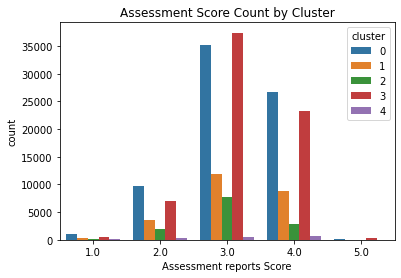

In [20]:
sns.countplot('Assessment reports Score', hue = 'cluster', data = df)
plt.title('Assessment Score Count by Cluster')

Text(0.5, 1.0, 'Normalized Assessment Score Count by Cluster')

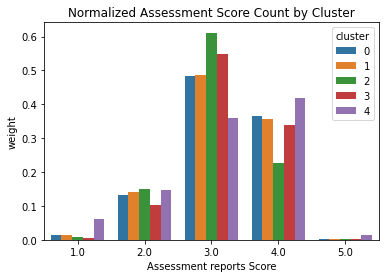

In [21]:
norm_df = df["Assessment reports Score"].groupby(df["cluster"]).value_counts().rename('count').reset_index()
norm_df = norm_df.assign(weight=norm_df['count']/norm_df.groupby('cluster')['count'].transform('sum'))

sns.barplot(x="Assessment reports Score", y="weight", hue = 'cluster', data=norm_df)
plt.title('Normalized Assessment Score Count by Cluster')

Text(0.5, 1.0, 'Normalized College count by Cluster')

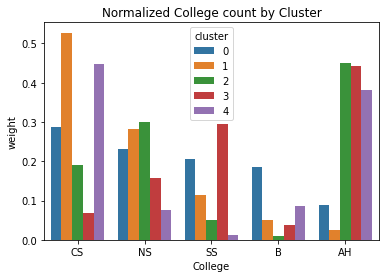

In [22]:
norm_df_2 = df["College"].groupby(df["cluster"]).value_counts().rename('count').reset_index()
norm_df_2 = norm_df_2.assign(weight=norm_df_2['count']/norm_df_2.groupby('cluster')['count'].transform('sum'))

sns.barplot(x="College", y="weight", hue = 'cluster', data=norm_df_2)

plt.title('Normalized College count by Cluster')

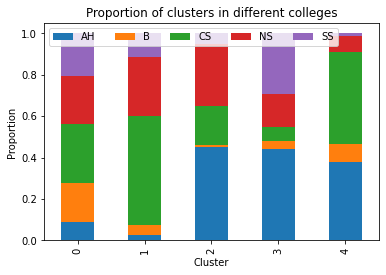

In [23]:
cross_tab_prop = pd.crosstab(index=df['cluster'],
                             columns=df['College'],
                             normalize="index")
cross_tab_prop


cross_tab_prop.plot(kind='bar', 
                    stacked=True)

plt.legend(loc="upper left", ncol = 5)
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.title("Proportion of clusters in different colleges")
plt.show()


### 10 clusters

In [24]:
km_10 = KMeans(n_clusters=10)

%time km_10.fit(tfidf_matrix)

clusters10 = km_10.labels_.tolist()

df['cluster10'] = np.array(clusters10)
terms10 = tfidf_vector.get_feature_names_out()

CPU times: user 2min 13s, sys: 5.63 s, total: 2min 18s
Wall time: 1min 18s


In [25]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km_10.cluster_centers_.argsort()[:, ::-1] 

for i in range(10):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :15]: #replace 6 with n words per cluster
        print(' %s' % terms10[ind],end=',')
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: doc, https, com, googl, edit, document, usp, share, kgi, edu, minerva, spreadsheet, drive, colab, gid,
Cluster 1 words: argument, thesi, sentenc, evid, induct, logic, premis, deduct, conclus, true, statement, use, truth, claim, clone,
Cluster 2 words: distribut, sampl, probabl, normal, mean, score, interv, calcul, use, would, confid, valu, size, trial, popul,
Cluster 3 words: would, time, use, function, valu, number, becaus, one, chang, node, vector, tree, get, first, point,
Cluster 4 words: data, variabl, model, hypothesi, studi, test, observ, use, would, differ, predict, control, treatment, regress, one,
Cluster 5 words: problem, solut, solv, constraint, water, use, rightproblem, identifi, state, differ, goal, breakitdown, subproblem, step, one,
Cluster 6 words: poll, complet, student, present, fac, facil, facia, facial, facialex, facialexpress, facien, faciilit, facilat, facevook, facili,
Cluster 7 words: compani, market, product, custom, ris

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Assessment Score Count by Cluster')

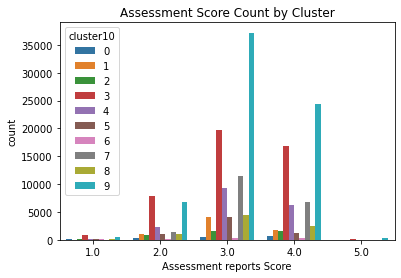

In [26]:
sns.countplot('Assessment reports Score', hue = 'cluster10', data = df)
plt.title('Assessment Score Count by Cluster')

Text(0.5, 1.0, 'Normalized Assessment Score Count by Cluster')

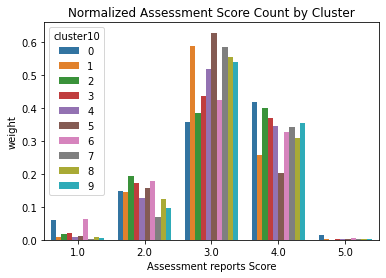

In [27]:
norm_df10 = df["Assessment reports Score"].groupby(df["cluster10"]).value_counts().rename('count').reset_index()
norm_df10 = norm_df10.assign(weight=norm_df10['count']/norm_df10.groupby('cluster10')['count'].transform('sum'))

sns.barplot(x="Assessment reports Score", y="weight", hue = 'cluster10', data=norm_df10)
plt.title('Normalized Assessment Score Count by Cluster')

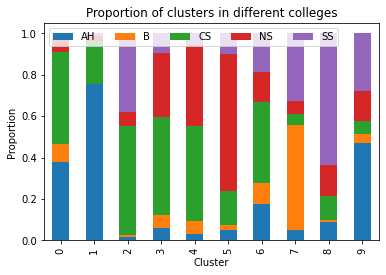

In [28]:
cross_tab_prop = pd.crosstab(index=df['cluster10'],
                             columns=df['College'],
                             normalize="index")
cross_tab_prop


cross_tab_prop.plot(kind='bar', 
                    stacked=True)

plt.legend(loc="upper left", ncol = 5)
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.title("Proportion of clusters in different colleges")
plt.show()
